Included for reproducibility of the conditional text data

In [1]:
from bikebench.resource_utils import datasets_path

In [ ]:
import os, getpass
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY") or getpass.getpass("OpenAI API key: ")
MODEL_ID = "gpt-5-mini"  

In [ ]:
import os
import json
import time
import argparse
from datetime import datetime
from typing import List, Dict

from openai import OpenAI

MODEL_ID = os.getenv("MODEL_ID", "gpt-5-mini") 

def build_mixed_prompt(n: int) -> str:
    return (
        f"I am trying to train a conditional model to generate bikes based on text descriptions. "
        f"I need a dataset of random text descriptions of bikes and I will train the bike using CLIP similarity. "
        f"You can mention different types of bikes, visual descriptions such as color, aesthetics, component classes, etc. "
        f"Can you create {n} such descriptions with very different styles. "
        f"Some should sound as if they are being described by various bicycle enthusiasts describing high performance bikes or referencing specific hobbyist goals. "
        f"Remember there are all sorts of cycling hobbies. "
        f"Some might sound like bicycle designers, engineers, or framebuilders who will have a more objective, professional tone. "
        f"Some should also sound like they are descriptions from casual users who may not have technical knowledge but may have a more simple or subjective way of describing a bike. "
        f"However, you should avoid mentioning anything about the person describing the bike. We are just looking for the description of the bike itself."
        f"Please count them off so you make sure you get to {n}. "
        f"And please make sure it is a description of a bike. Something in the description should make it clear that it's a bicycle."
    )

def build_format_instruction_strict(n: int) -> str:
    return (
        "OUTPUT FORMAT ONLY (do not change content rules):\n"
        f"- Return EXACTLY {n} lines as a single numbered list.\n"
        f"- Number strictly from 1 to {n} using a period: '1. …', '2. …', '3. …'.\n"
        "- No other separators, no headings, no blank lines, no extra text.\n"
        "- Each line MUST contain only the description text after the number and period."
    )

import re, json
from typing import List
from openai import OpenAI

MODEL_ID = "gpt-5-mini"  # change if needed

_numline_re = re.compile(r"^\s*(\d+)\.\s+(.+?)\s*$")

def _split_numbered_lines_strict(text: str, n: int) -> List[str]:
    nums, descs = [], []
    for raw in text.splitlines():
        m = _numline_re.match(raw)
        if m:
            nums.append(int(m.group(1)))
            descs.append(m.group(2).strip())
    if len(descs) != n or nums != list(range(1, n + 1)):
        raise ValueError(
            f"Strict parse failed. Expected 1..{n}. "
            f"Parsed {len(descs)} items; first numbers: {nums[:10]}"
        )
    return descs

def generate_batch_text_mixed(n: int = 500, model: str = MODEL_ID) -> List[str]:
    client = OpenAI()
    dev = build_format_instruction_strict(n)
    user = build_mixed_prompt(n)

    # First attempt
    resp = client.responses.create(
        model=model,
        input=[
            {"role": "developer", "content": dev},
            {"role": "user", "content": user},
        ],
    )
    try:
        text = resp.output_text
    except Exception:
        text = resp.output[0].content[0].text

    try:
        items = _split_numbered_lines_strict(text, n)
        return items
    except ValueError:
        resp2 = client.responses.create(
            model=model,
            input=[
                {"role": "developer",
                 "content": f"Return EXACTLY {n} lines numbered '1. ...' through '{n}. ...'. No headings or blank lines."},
                {"role": "user", "content": user},
            ],
        )
        try:
            text2 = resp2.output_text
        except Exception:
            text2 = resp2.output[0].content[0].text
        items = _split_numbered_lines_strict(text2, n)
        return items

import os
from datetime import datetime

def save_txt_lines(lines: List[str], out_dir: str = "out_bikes", tag: str = "") -> str:
    os.makedirs(out_dir, exist_ok=True)
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    path = os.path.join(out_dir, f"bike_descriptions_{len(lines)}_{ts}{('_' + tag) if tag else ''}.txt")
    with open(path, "w", encoding="utf-8") as f:
        for line in lines:
            f.write(line.replace("\n", " ").strip() + "\n")
    return path

def run_batches_txt(batches: int,
                    n: int = 500,
                    model: str = MODEL_ID,
                    outfile: str = "out_bikes/all.txt",
                    sleep_s: float = 0.0,
                    truncate: bool = True):
    os.makedirs(os.path.dirname(outfile) or ".", exist_ok=True)
    if truncate:
        open(outfile, "w", encoding="utf-8").close()

    for i in range(batches):
        print(f"Batch {i+1}/{batches} → requesting {n} items...")
        lines = generate_batch_text_mixed(n=n, model=model)
        with open(outfile, "a", encoding="utf-8") as f:
            for line in lines:
                f.write(line.replace("\n", " ").strip() + "\n")
        print(f"Appended {len(lines)} lines → {outfile}")
        if i < batches - 1 and sleep_s > 0:
            import time; time.sleep(sleep_s)


In [9]:
from tqdm import trange
for i in trange(17):
    lines = generate_batch_text_mixed(n=500, model=MODEL_ID)
    txt_path = save_txt_lines(lines, out_dir=datasets_path("text"), tag="n500_once")

100%|██████████| 17/17 [55:39<00:00, 196.46s/it]


In [10]:
#load all the files and combine them into one
all_lines = []
for fname in os.listdir(datasets_path("text")):
    if fname.endswith(".txt") and "n500_once" in fname:
        with open(os.path.join(datasets_path("text"), fname), "r", encoding="utf-8") as f:
            all_lines.extend([line.strip() for line in f if line.strip()])


In [11]:
len(all_lines)

#split 

10000

Text(0, 0.5, 'Frequency')

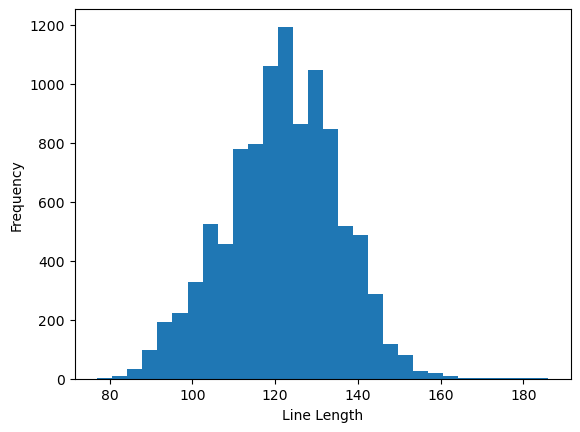

In [12]:
#get histogram of line lengths
import matplotlib.pyplot as plt
lengths = [len(line) for line in all_lines]
plt.hist(lengths, bins=30)
plt.xlabel("Line Length")
plt.ylabel("Frequency")

In [ ]:
#split into 9900 and 100

from sklearn.model_selection import train_test_split
train_lines, test_lines = train_test_split(all_lines, test_size=100, random_state=42)

#save to Random_Text_Descriptions/ train and test.txt
with open(datasets_path("Conditioning/text_train.txt"), "w", encoding="utf-8") as f:
    for line in train_lines:
        f.write(line + "\n")
with open(datasets_path("Conditioning/text_test.txt"), "w", encoding="utf-8") as f:
    for line in test_lines:
        f.write(line + "\n")

In [18]:
#load the train and test and feed through clip embeddings and save as np files

import torch
from bikebench.embedding.clip_embedding_calculator import ClipEmbeddingCalculator

calc = ClipEmbeddingCalculator(device="cuda" if torch.cuda.is_available() else "cpu")
train_tens = calc.embed_texts(train_lines)
test_tens = calc.embed_texts(test_lines)

import numpy as np
np.save(datasets_path("Conditioning/emb_train.npy"), train_tens.detach().cpu().numpy())
np.save(datasets_path("Conditioning/emb_test.npy"), test_tens.detach().cpu().numpy())
